# 杜邦分析選股策略

本策略分成以下兩部分：
- 運用 TejToolAPI 抓取杜邦選股策略所需之財務面日資料，將資料進行清洗與篩選後，找出符合選股策略的標的。
- 運用 TQuant Lab 將標的進行買進持有一年 (2023-01-01 至 2023-12-31)，觀察其風險與報酬表現。

杜邦 4 大選股條件如下：
1a. 最近年度股東權益報酬率 ＞ 平均值 (市場及產業)
1b. 過去三年CAGR>10%
2a. 最近資產周轉率 ＞ 平均值 (市場及產業)
2b. 過去三年CAGR>5%
3a. 最近年度淨利率 ＞ 產業平均值
3b. 過去三年淨利率標準差<10%
4.  權益成數小於２

## 設定基本套件與環境

``` python
os.environ['TEJAPI_KEY'] = tej_key    ==> 個人 api key 以驗證身分。
os.environ['TEJAPI_BASE'] = api_base  ==> 導航至 tej api 網域。
```

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# tej_key
tej_key = 'TN3Amte31lIzT8pHhxs8buSLIv8z2G'
api_base = 'https://api.tej.com.tw'


os.environ['TEJAPI_KEY'] = tej_key 
os.environ['TEJAPI_BASE'] = api_base

## 使用 `get_universe()` 函式取得股票池
`get_universe()` 函數可以幫助我們抓取特定的股票池（市場、板塊、證券種類、產業）。  
由於巴菲特的投資法則希望標的上市時間大於一定的年限，因此我們選取 2021 年初即已上市的公司。  
另外，因為 ROE 可以藉由舉債來提升，因此我們排除金融產業這類高槓桿的產業。

p.s. 關於 `get_universe()` 的說明，可參考 TQuant Lab github：[get_universe 說明](https://github.com/tejtw/TQuant-Lab/blob/main/lecture/get_universe%E8%AA%AA%E6%98%8E.ipynb)

In [17]:
from zipline.sources.TEJ_Api_Data import get_universe

pool = get_universe(start = '2019-01-01', 
                    end = '2019-01-04',  # 選取 2019 年年初已上市的股票
                    mkt_bd_e = 'TSE',  # 填入：上市一般版股票
                    stktp_e='common stock',  # 填入：普通股股票 
                    main_ind_e = 'General Industry') # general industry 篩掉金融產業
pool

Currently used TEJ API key call quota 78/1000 (7.8%)
Currently used TEJ API key data quota 1849858/10000000 (18.5%)


['1101',
 '1102',
 '1103',
 '1104',
 '1108',
 '1109',
 '1110',
 '1201',
 '1203',
 '1210',
 '1213',
 '1215',
 '1216',
 '1217',
 '1218',
 '1219',
 '1220',
 '1225',
 '1227',
 '1229',
 '1231',
 '1232',
 '1233',
 '1234',
 '1235',
 '1236',
 '1301',
 '1303',
 '1304',
 '1305',
 '1307',
 '1308',
 '1309',
 '1310',
 '1312',
 '1313',
 '1314',
 '1315',
 '1316',
 '1319',
 '1321',
 '1323',
 '1324',
 '1325',
 '1326',
 '1339',
 '1402',
 '1409',
 '1410',
 '1413',
 '1414',
 '1416',
 '1417',
 '1418',
 '1419',
 '1423',
 '1432',
 '1434',
 '1435',
 '1436',
 '1437',
 '1438',
 '1439',
 '1440',
 '1441',
 '1442',
 '1443',
 '1444',
 '1445',
 '1446',
 '1447',
 '1449',
 '1451',
 '1452',
 '1453',
 '1454',
 '1455',
 '1456',
 '1457',
 '1459',
 '1460',
 '1463',
 '1464',
 '1465',
 '1466',
 '1467',
 '1468',
 '1470',
 '1471',
 '1472',
 '1473',
 '1474',
 '1475',
 '1476',
 '1477',
 '1503',
 '1504',
 '1506',
 '1507',
 '1512',
 '1513',
 '1514',
 '1515',
 '1516',
 '1517',
 '1519',
 '1521',
 '1522',
 '1524',
 '1525',
 '1526',
 

In [18]:
len(pool)  # 818

818

## 利用 TejToolAPI 抓取所需的財務資料
根據上述選股條件，我們需要的財務科目有以下 5 項：
1. 主產業別_中文
2. 常續ROE
3. 營業毛利率
4. 營運產生現金流量
5. 投資產生現金流量

註： 
- TejToolAPI 的詳細使用方法可參考 TQuant Lab github：[TejToolAPI 說明](https://github.com/tejtw/TQuant-Lab/blob/main/lecture/Data%20Preprocess%20-%20tejtoolapi.ipynb)
- TejToolAPI 提供之資料集可參考 TQuant Lab 官網：[TQuant Lab 資料集](https://tquant.tejwin.com/%e8%b3%87%e6%96%99%e9%9b%86/)

In [19]:
#can't use five years-change into 3 years
import TejToolAPI

start_time = pd.Timestamp('2019-01-01')
end_time = pd.Timestamp('2023-12-30')  # 將時間字串轉換成時間格式

data = TejToolAPI.get_history_data(start = start_time,
                                   end = end_time,
                                   ticker = pool,  # 填入：正確參數名稱 & 股票池列表 ( list )
                                   fin_type = 'A', # 為累計資料，舉例來說，Q3累計：1月～9月的資料。
                                   columns = ['主產業別_中文', '常續ROE', '總資產週轉率', '稅後淨利率', '權益乘數'],
                                   transfer_to_chinese = True)

# Check column names of the data DataFrame
print(data.columns)

# Modify the code based on the column names
if 'mdate' in data.columns:
    data['mdate'] = data['mdate'].astype('datetime64[ms]')

data

Currently used TEJ API key call quota 149/1000 (14.9%)
Currently used TEJ API key data quota 3581885/10000000 (35.82%)
Index(['股票代碼', '日期', '主產業別_中文', '稅後淨利率_A', '總資產週轉率_A', '常續ROE_A'], dtype='object')


,股票代碼,日期,主產業別_中文,稅後淨利率_A,總資產週轉率_A,常續ROE_A
0,1101,2021-01-04 00:00:00,M1100 水泥工業,NaN,NaN,NaN
1,1102,2021-01-04 00:00:00,M1100 水泥工業,NaN,NaN,NaN
2,1103,2021-01-04 00:00:00,M1100 水泥工業,NaN,NaN,NaN
3,1104,2021-01-04 00:00:00,M1100 水泥工業,NaN,NaN,NaN
4,1108,2021-01-04 00:00:00,M1100 水泥工業,NaN,NaN,NaN
...,...,...,...,...,...,...
584353,9944,2023-12-29 00:00:00,M9900 其他,11.79,0.27,-5.18
584354,9945,2023-12-29 00:00:00,M9900 其他,63.00,0.11,13.96
584355,9946,2023-12-29 00:00:00,M2500 建材營造,2.22,0.04,0.21
584356,9955,2023-12-29 00:00:00,M3500 綠能環保,-6.27,0.30,-4.71


## 選股條件 1：最近年度股東權益報酬率＞平均值(市場及產業)+ROE cagr>10%

In [21]:
# 取出最近年度(2023-12-30)的資料
data['日期'] = pd.to_datetime(data['日期'])
data_last_1Y = data[data['日期'] == '2023-12-29 00:00:00'].reset_index(drop = True)  

# 取出股票基本資料與 ROE 資料方便觀察
ROE_1Y_data = data_last_1Y[['股票代碼', '日期', '主產業別_中文', '常續ROE_A']]

ROE_1Y_data

,股票代碼,日期,主產業別_中文,常續ROE_A
0,1101,2023-12-29,M1100 水泥工業,2.76
1,1102,2023-12-29,M1100 水泥工業,3.51
2,1103,2023-12-29,M1100 水泥工業,-0.41
3,1104,2023-12-29,M1100 水泥工業,4.40
4,1108,2023-12-29,M1100 水泥工業,7.56
...,...,...,...,...
791,9944,2023-12-29,M9900 其他,-5.18
792,9945,2023-12-29,M9900 其他,13.96
793,9946,2023-12-29,M2500 建材營造,0.21
794,9955,2023-12-29,M3500 綠能環保,-4.71


In [22]:
# 依不同產業分類，計算出產業平均 ROE
# 填入：欲進行分類的財務科目
industry_ROE_ave = ROE_1Y_data.groupby('主產業別_中文')['常續ROE_A'].transform('mean') 

# 加入 '產業平均ROE' 欄位
ROE_1Y_data['產業平均ROE'] = industry_ROE_ave
 
ROE_1Y_data

,股票代碼,日期,主產業別_中文,常續ROE_A,產業平均ROE
0,1101,2023-12-29,M1100 水泥工業,2.76,3.260000
1,1102,2023-12-29,M1100 水泥工業,3.51,3.260000
2,1103,2023-12-29,M1100 水泥工業,-0.41,3.260000
3,1104,2023-12-29,M1100 水泥工業,4.40,3.260000
4,1108,2023-12-29,M1100 水泥工業,7.56,3.260000
...,...,...,...,...,...
791,9944,2023-12-29,M9900 其他,-5.18,4.521064
792,9945,2023-12-29,M9900 其他,13.96,4.521064
793,9946,2023-12-29,M2500 建材營造,0.21,5.565000
794,9955,2023-12-29,M3500 綠能環保,-4.71,4.046667


In [23]:
#計算3年ROE複合成長率>10%
ROE_cagr_data = data[['股票代碼', '日期', '主產業別_中文', '常續ROE_A']]

In [24]:
ROE_cagr_data

,股票代碼,日期,主產業別_中文,常續ROE_A
0,1101,2021-01-04,M1100 水泥工業,NaN
1,1102,2021-01-04,M1100 水泥工業,NaN
2,1103,2021-01-04,M1100 水泥工業,NaN
3,1104,2021-01-04,M1100 水泥工業,NaN
4,1108,2021-01-04,M1100 水泥工業,NaN
...,...,...,...,...
584353,9944,2023-12-29,M9900 其他,-5.18
584354,9945,2023-12-29,M9900 其他,13.96
584355,9946,2023-12-29,M2500 建材營造,0.21
584356,9955,2023-12-29,M3500 綠能環保,-4.71


In [25]:
# 取出近3年(2023-12-29, 2022-12-30, 2021-12-30)的資料
data_last_3Y = data[data['日期'].isin(['2023-12-29','2022-12-30', '2021-12-30'])].reset_index(drop = True)

# 篩選出有兩筆以上資料的股票代碼
data_last_3Y = data_last_3Y.groupby('股票代碼').filter(lambda x: len(x) >= 3)

# 計算公司三年ROE的CAGR
ROE_3Y_cagr = data_last_3Y.groupby('股票代碼')['常續ROE_A'].apply(lambda x: (x.iloc[1] / x.iloc[0]) ** (1 / 3) - 1)

# 從 Series 轉成 Dataframe，並重新命名欄位
ROE_3Y_cagr = pd.DataFrame(ROE_3Y_cagr).rename(columns = {'常續ROE_A': '3年ROE_CAGR'})

ROE_3Y_cagr

,3年ROE_CAGR
股票代碼,
1101,NaN
1102,-0.085828
1103,-0.189585
1104,0.193483
1108,0.216440
...,...
9944,0.134097
9945,0.183449
9946,-0.133378


In [26]:
set_1a = set(ROE_1Y_data[ROE_1Y_data['常續ROE_A'] > ROE_1Y_data['產業平均ROE']]['股票代碼'])  # 篩選符合選股條件的公司
set_1a

{'1102',
 '1104',
 '1108',
 '1109',
 '1201',
 '1203',
 '1210',
 '1215',
 '1216',
 '1219',
 '1225',
 '1227',
 '1229',
 '1231',
 '1232',
 '1233',
 '1235',
 '1301',
 '1303',
 '1305',
 '1307',
 '1308',
 '1315',
 '1319',
 '1321',
 '1323',
 '1324',
 '1325',
 '1339',
 '1402',
 '1409',
 '1410',
 '1414',
 '1419',
 '1423',
 '1434',
 '1437',
 '1439',
 '1443',
 '1444',
 '1445',
 '1449',
 '1452',
 '1454',
 '1463',
 '1464',
 '1465',
 '1468',
 '1470',
 '1473',
 '1475',
 '1476',
 '1477',
 '1503',
 '1513',
 '1514',
 '1515',
 '1519',
 '1522',
 '1524',
 '1526',
 '1527',
 '1532',
 '1535',
 '1537',
 '1540',
 '1558',
 '1560',
 '1568',
 '1582',
 '1604',
 '1612',
 '1615',
 '1616',
 '1702',
 '1707',
 '1712',
 '1713',
 '1717',
 '1720',
 '1722',
 '1723',
 '1726',
 '1730',
 '1731',
 '1733',
 '1734',
 '1762',
 '1773',
 '1783',
 '1786',
 '1808',
 '1817',
 '1904',
 '1906',
 '1907',
 '2006',
 '2010',
 '2012',
 '2013',
 '2015',
 '2020',
 '2027',
 '2028',
 '2029',
 '2031',
 '2049',
 '2059',
 '2103',
 '2105',
 '2106',
 

In [27]:
len(set_1a)  # 414

414

In [28]:
set_1b= set(ROE_3Y_cagr[ROE_3Y_cagr['3年ROE_CAGR'] > 0.1].index)
set_1b

{'1104',
 '1108',
 '1234',
 '1235',
 '1307',
 '1319',
 '1339',
 '1413',
 '1438',
 '1439',
 '1441',
 '1443',
 '1444',
 '1451',
 '1453',
 '1454',
 '1459',
 '1463',
 '1464',
 '1470',
 '1475',
 '1506',
 '1517',
 '1519',
 '1521',
 '1522',
 '1524',
 '1526',
 '1527',
 '1528',
 '1530',
 '1531',
 '1536',
 '1537',
 '1538',
 '1539',
 '1541',
 '1560',
 '1582',
 '1583',
 '1611',
 '1708',
 '1712',
 '1713',
 '1723',
 '1760',
 '1789',
 '1805',
 '1809',
 '2008',
 '2013',
 '2059',
 '2062',
 '2206',
 '2208',
 '2228',
 '2302',
 '2303',
 '2312',
 '2313',
 '2342',
 '2345',
 '2356',
 '2359',
 '2360',
 '2363',
 '2365',
 '2367',
 '2368',
 '2371',
 '2387',
 '2392',
 '2397',
 '2402',
 '2404',
 '2405',
 '2406',
 '2419',
 '2421',
 '2423',
 '2425',
 '2429',
 '2434',
 '2439',
 '2449',
 '2466',
 '2468',
 '2471',
 '2474',
 '2484',
 '2488',
 '2493',
 '2495',
 '2506',
 '2511',
 '2514',
 '2515',
 '2534',
 '2539',
 '2543',
 '2548',
 '2601',
 '2606',
 '2607',
 '2612',
 '2634',
 '2701',
 '2706',
 '2707',
 '2731',
 '2903',
 

In [29]:
len(set_1b) #222

222

## 選股條件 2：資產周轉率高於產業平均＋三年CAGR>5%

In [30]:
# 取出最近年度(2023-12-30)的資料
data['日期'] = pd.to_datetime(data['日期'])
TA_turnover_1Y_data = data[data['日期'] == '2023-12-29 00:00:00'].reset_index(drop = True)  

# 取出股票基本資料與 ROE 資料方便觀察
TA_turnover_1Y_data = TA_turnover_1Y_data[['股票代碼', '日期', '主產業別_中文', '總資產週轉率_A']]

TA_turnover_1Y_data

,股票代碼,日期,主產業別_中文,總資產週轉率_A
0,1101,2023-12-29,M1100 水泥工業,0.17
1,1102,2023-12-29,M1100 水泥工業,0.19
2,1103,2023-12-29,M1100 水泥工業,0.06
3,1104,2023-12-29,M1100 水泥工業,0.20
4,1108,2023-12-29,M1100 水泥工業,0.38
...,...,...,...,...
791,9944,2023-12-29,M9900 其他,0.27
792,9945,2023-12-29,M9900 其他,0.11
793,9946,2023-12-29,M2500 建材營造,0.04
794,9955,2023-12-29,M3500 綠能環保,0.30


In [31]:
industry_TA_turnover_ave =TA_turnover_1Y_data.groupby('主產業別_中文')['總資產週轉率_A'].transform('mean') 

# 加入 '產業平均TA_turnover' 欄位
TA_turnover_1Y_data['產業平均TA_turnover'] = industry_TA_turnover_ave
 
TA_turnover_1Y_data

,股票代碼,日期,主產業別_中文,總資產週轉率_A,產業平均TA_turnover
0,1101,2023-12-29,M1100 水泥工業,0.17,0.221429
1,1102,2023-12-29,M1100 水泥工業,0.19,0.221429
2,1103,2023-12-29,M1100 水泥工業,0.06,0.221429
3,1104,2023-12-29,M1100 水泥工業,0.20,0.221429
4,1108,2023-12-29,M1100 水泥工業,0.38,0.221429
...,...,...,...,...,...
791,9944,2023-12-29,M9900 其他,0.27,0.429362
792,9945,2023-12-29,M9900 其他,0.11,0.429362
793,9946,2023-12-29,M2500 建材營造,0.04,0.208077
794,9955,2023-12-29,M3500 綠能環保,0.30,0.271667


In [32]:
set_2a = set(TA_turnover_1Y_data[TA_turnover_1Y_data['總資產週轉率_A'] > TA_turnover_1Y_data['產業平均TA_turnover']]['股票代碼'])  # 篩選符合選股條件的公司
set_2a

{'1108',
 '1109',
 '1201',
 '1210',
 '1215',
 '1216',
 '1219',
 '1220',
 '1225',
 '1227',
 '1231',
 '1232',
 '1304',
 '1305',
 '1307',
 '1309',
 '1310',
 '1313',
 '1319',
 '1324',
 '1413',
 '1441',
 '1445',
 '1447',
 '1451',
 '1454',
 '1455',
 '1460',
 '1464',
 '1466',
 '1467',
 '1470',
 '1472',
 '1473',
 '1474',
 '1475',
 '1476',
 '1477',
 '1503',
 '1514',
 '1515',
 '1516',
 '1519',
 '1521',
 '1522',
 '1528',
 '1535',
 '1537',
 '1538',
 '1539',
 '1541',
 '1558',
 '1560',
 '1605',
 '1612',
 '1614',
 '1615',
 '1616',
 '1617',
 '1618',
 '1701',
 '1707',
 '1709',
 '1710',
 '1711',
 '1712',
 '1714',
 '1717',
 '1723',
 '1725',
 '1726',
 '1727',
 '1730',
 '1732',
 '1733',
 '1735',
 '1736',
 '1760',
 '1773',
 '1776',
 '1808',
 '1817',
 '1904',
 '1905',
 '1906',
 '1907',
 '1909',
 '2006',
 '2010',
 '2013',
 '2014',
 '2015',
 '2020',
 '2022',
 '2028',
 '2029',
 '2030',
 '2032',
 '2038',
 '2069',
 '2103',
 '2105',
 '2106',
 '2108',
 '2109',
 '2114',
 '2204',
 '2206',
 '2208',
 '2227',
 '2228',
 

In [33]:
len(set_2a)#323

323

In [34]:
# 取出近3年(2023-12-29, 2022-12-30, 2021-12-30)的資料
data_last_3Y = data[data['日期'].isin(['2023-12-29','2022-12-30', '2021-12-30'])].reset_index(drop = True)

# 篩選出有3筆以上資料的股票代碼
data_last_3Y = data_last_3Y.groupby('股票代碼').filter(lambda x: len(x) >= 3)

# 計算公司兩年TA_turnover的CAGR
TA_turnover_3Y_cagr = data_last_3Y.groupby('股票代碼')['總資產週轉率_A'].apply(lambda x: (x.iloc[1] / x.iloc[0]) ** (1 / 3) - 1)

# 從 Series 轉成 Dataframe，並重新命名欄位
TA_turnover_3Y_cagr = pd.DataFrame(TA_turnover_3Y_cagr).rename(columns = {'總資產週轉率_A': '3年TA_turnover_CAGR'})

TA_turnover_3Y_cagr

,3年TA_turnover_CAGR
股票代碼,
1101,-0.017861
1102,-0.015387
1103,0.000000
1104,0.018186
1108,-0.027792
...,...
9944,-0.026328
9945,0.108918
9946,0.130404


In [35]:
set_2b= set(TA_turnover_3Y_cagr[TA_turnover_3Y_cagr['3年TA_turnover_CAGR'] > 0.05].index)
set_2b

{'1307',
 '1310',
 '1315',
 '1316',
 '1319',
 '1413',
 '1416',
 '1432',
 '1436',
 '1437',
 '1438',
 '1439',
 '1453',
 '1454',
 '1463',
 '1464',
 '1465',
 '1472',
 '1473',
 '1475',
 '1516',
 '1524',
 '1537',
 '1538',
 '1539',
 '1540',
 '1603',
 '1616',
 '1708',
 '1721',
 '1722',
 '1723',
 '1734',
 '1760',
 '1805',
 '1809',
 '1906',
 '2008',
 '2013',
 '2102',
 '2302',
 '2313',
 '2331',
 '2359',
 '2367',
 '2374',
 '2404',
 '2424',
 '2488',
 '2491',
 '2497',
 '2511',
 '2530',
 '2534',
 '2535',
 '2536',
 '2539',
 '2545',
 '2547',
 '2548',
 '2607',
 '2610',
 '2612',
 '2618',
 '2633',
 '2634',
 '2702',
 '2705',
 '2712',
 '2722',
 '2731',
 '2739',
 '2748',
 '2901',
 '2910',
 '2915',
 '3002',
 '3004',
 '3035',
 '3046',
 '3051',
 '3056',
 '3059',
 '3062',
 '3229',
 '3266',
 '3454',
 '3494',
 '3535',
 '3576',
 '3617',
 '3703',
 '4142',
 '4155',
 '4164',
 '4426',
 '4438',
 '4915',
 '4934',
 '5203',
 '5258',
 '5388',
 '5519',
 '5521',
 '5525',
 '5533',
 '5534',
 '5608',
 '6133',
 '6139',
 '6177',
 

In [36]:
len(set_2b)

137

## 選股條件 3：最近年淨利率＞產業平均值＋標準差低於 10% 的股票

In [37]:
# 取出股票基本資料與 Net Income 資料方便觀察
NI_1Y_data = data_last_1Y[['股票代碼', '日期', '主產業別_中文', '稅後淨利率_A']]

NI_1Y_data

,股票代碼,日期,主產業別_中文,稅後淨利率_A
0,1101,2023-12-29,M1100 水泥工業,9.27
1,1102,2023-12-29,M1100 水泥工業,15.74
2,1103,2023-12-29,M1100 水泥工業,6.98
3,1104,2023-12-29,M1100 水泥工業,33.21
4,1108,2023-12-29,M1100 水泥工業,12.70
...,...,...,...,...
791,9944,2023-12-29,M9900 其他,11.79
792,9945,2023-12-29,M9900 其他,63.00
793,9946,2023-12-29,M2500 建材營造,2.22
794,9955,2023-12-29,M3500 綠能環保,-6.27


In [38]:
# 依不同產業分類，計算出產業平均 GM
# 填入：分類函數 & 欲進行分類的財務科目 & 欲計算平均的財務科目 
industry_NI_ave = NI_1Y_data.groupby('主產業別_中文')['稅後淨利率_A'].transform('mean')  

# 加入 '產業平均毛利率' 欄位
NI_1Y_data['產業平均淨利率'] = industry_NI_ave

NI_1Y_data

,股票代碼,日期,主產業別_中文,稅後淨利率_A,產業平均淨利率
0,1101,2023-12-29,M1100 水泥工業,9.27,14.091429
1,1102,2023-12-29,M1100 水泥工業,15.74,14.091429
2,1103,2023-12-29,M1100 水泥工業,6.98,14.091429
3,1104,2023-12-29,M1100 水泥工業,33.21,14.091429
4,1108,2023-12-29,M1100 水泥工業,12.70,14.091429
...,...,...,...,...,...
791,9944,2023-12-29,M9900 其他,11.79,10.476170
792,9945,2023-12-29,M9900 其他,63.00,10.476170
793,9946,2023-12-29,M2500 建材營造,2.22,20.823846
794,9955,2023-12-29,M3500 綠能環保,-6.27,13.356667


In [87]:
NI_1Y_data.drop('產業平均淨利率', axis = 1, inplace = True)

In [39]:
# 篩選符合選股條件的公司
# 填入：正確的篩選條件
set_3a = set(NI_1Y_data[NI_1Y_data['稅後淨利率_A'] > NI_1Y_data['產業平均淨利率']]['股票代碼'])
set_3a

{'1102',
 '1104',
 '1203',
 '1229',
 '1234',
 '1235',
 '1301',
 '1303',
 '1305',
 '1307',
 '1308',
 '1315',
 '1319',
 '1321',
 '1323',
 '1324',
 '1325',
 '1339',
 '1402',
 '1409',
 '1410',
 '1414',
 '1416',
 '1417',
 '1419',
 '1423',
 '1434',
 '1437',
 '1439',
 '1440',
 '1442',
 '1443',
 '1444',
 '1445',
 '1447',
 '1449',
 '1452',
 '1453',
 '1454',
 '1459',
 '1463',
 '1464',
 '1465',
 '1468',
 '1470',
 '1473',
 '1475',
 '1476',
 '1477',
 '1503',
 '1504',
 '1506',
 '1514',
 '1519',
 '1524',
 '1525',
 '1526',
 '1527',
 '1529',
 '1530',
 '1532',
 '1537',
 '1540',
 '1558',
 '1560',
 '1568',
 '1582',
 '1583',
 '1603',
 '1604',
 '1608',
 '1609',
 '1611',
 '1612',
 '1615',
 '1707',
 '1713',
 '1718',
 '1720',
 '1722',
 '1723',
 '1726',
 '1730',
 '1731',
 '1734',
 '1737',
 '1762',
 '1773',
 '1783',
 '1786',
 '1808',
 '1817',
 '1903',
 '2006',
 '2008',
 '2010',
 '2015',
 '2020',
 '2027',
 '2028',
 '2029',
 '2031',
 '2049',
 '2059',
 '2101',
 '2103',
 '2104',
 '2105',
 '2106',
 '2107',
 '2108',
 

In [40]:
len(set_3a)  # 382

382

In [41]:
# 取出近3年(2022-12-30, 2021-12-30,2023-12-29)的資料
data_last_3Y_2 = data[data['日期'].isin(['2023-12-29','2022-12-30', '2021-12-30'])].reset_index(drop = True)

# 篩選出有兩筆以上資料的股票代碼
data_last_3Y_2 = data_last_3Y_2.groupby('股票代碼').filter(lambda x: len(x) >= 3)


NI_3Y_std = data_last_3Y_2.groupby('股票代碼')['稅後淨利率_A'].rolling(window=3).std()

# 從 Series 轉成 Dataframe，並重新命名欄位
NI_3Y_std = pd.DataFrame(NI_3Y_std).rename(columns={'稅後淨利率_A': '3年NI_std'}).reset_index()

NI_3Y_std

,股票代碼,level_1,3年NI_std
0,1101,0,NaN
1,1101,50,NaN
2,1101,100,9.669231
3,1102,1,NaN
4,1102,51,NaN
...,...,...,...
2383,9955,2379,NaN
2384,9955,2397,0.972163
2385,9958,2362,NaN
2386,9958,2380,NaN


In [42]:
NI_3Y_std.dropna(subset=['3年NI_std'], inplace=True)
NI_3Y_std

,股票代碼,level_1,3年NI_std
2,1101,100,9.669231
5,1102,101,2.050658
8,1103,102,27.441236
11,1104,103,8.282288
14,1108,104,3.496055
...,...,...,...
2375,9944,2394,5.005787
2378,9945,2395,6.922492
2381,9946,2396,5.568486
2384,9955,2397,0.972163


In [43]:
set_3b = set(NI_3Y_std.loc[NI_3Y_std['3年NI_std'] < 10, '股票代碼'])
set_3b

{'1101',
 '1102',
 '1104',
 '1108',
 '1109',
 '1110',
 '1201',
 '1203',
 '1210',
 '1215',
 '1216',
 '1217',
 '1218',
 '1219',
 '1220',
 '1225',
 '1227',
 '1229',
 '1231',
 '1232',
 '1233',
 '1234',
 '1303',
 '1304',
 '1305',
 '1307',
 '1309',
 '1310',
 '1313',
 '1319',
 '1321',
 '1323',
 '1324',
 '1325',
 '1326',
 '1402',
 '1409',
 '1410',
 '1413',
 '1414',
 '1416',
 '1417',
 '1434',
 '1442',
 '1443',
 '1444',
 '1445',
 '1446',
 '1447',
 '1449',
 '1451',
 '1452',
 '1454',
 '1455',
 '1460',
 '1464',
 '1466',
 '1467',
 '1468',
 '1470',
 '1472',
 '1473',
 '1474',
 '1475',
 '1476',
 '1477',
 '1503',
 '1504',
 '1506',
 '1513',
 '1514',
 '1515',
 '1516',
 '1517',
 '1519',
 '1521',
 '1522',
 '1524',
 '1525',
 '1526',
 '1527',
 '1528',
 '1530',
 '1531',
 '1532',
 '1533',
 '1535',
 '1536',
 '1537',
 '1538',
 '1539',
 '1541',
 '1558',
 '1560',
 '1582',
 '1583',
 '1587',
 '1598',
 '1603',
 '1604',
 '1605',
 '1608',
 '1609',
 '1611',
 '1612',
 '1614',
 '1615',
 '1616',
 '1617',
 '1618',
 '1701',
 

In [44]:
len(set_3b)#630

630

## 選股條件 4：權益乘數<2

In [45]:
import TejToolAPI

start_time = pd.Timestamp('2021-01-01')
end_time = pd.Timestamp('2023-12-30')  # 將時間字串轉換成時間格式

data2 = TejToolAPI.get_history_data(start = start_time,
                                   end = end_time,
                                   ticker = pool,  # 填入：正確參數名稱 & 股票池列表 ( list )
                                   fin_type = 'A', # 為累計資料，舉例來說，Q3累計：1月～9月的資料。
                                   columns = ['主產業別_中文', '常續ROE','資產總計'],
                                   transfer_to_chinese = True)

# Check column names of the data DataFrame
print(data.columns)

# Modify the code based on the column names
if 'mdate' in data2.columns:
    data2['mdate'] = data2['mdate'].astype('datetime64[ms]')

data2

Currently used TEJ API key call quota 222/1000 (22.2%)
Currently used TEJ API key data quota 4998744/10000000 (49.99%)
Index(['股票代碼', '日期', '主產業別_中文', '稅後淨利率_A', '總資產週轉率_A', '常續ROE_A'], dtype='object')


,股票代碼,日期,主產業別_中文,資產總計_A,常續ROE_A
0,1101,2021-01-04 00:00:00,M1100 水泥工業,NaN,NaN
1,1102,2021-01-04 00:00:00,M1100 水泥工業,NaN,NaN
2,1103,2021-01-04 00:00:00,M1100 水泥工業,NaN,NaN
3,1104,2021-01-04 00:00:00,M1100 水泥工業,NaN,NaN
4,1108,2021-01-04 00:00:00,M1100 水泥工業,NaN,NaN
...,...,...,...,...,...
584353,9944,2023-12-29 00:00:00,M9900 其他,6090557.0,-5.18
584354,9945,2023-12-29 00:00:00,M9900 其他,170238160.0,13.96
584355,9946,2023-12-29 00:00:00,M2500 建材營造,15490711.0,0.21
584356,9955,2023-12-29 00:00:00,M3500 綠能環保,2902920.0,-4.71


In [46]:
df = pd.DataFrame(data2)

In [47]:
leverage_ratio = df['資產總計_A'] / df['常續ROE_A']
df['權益乘數'] = leverage_ratio

In [48]:
df

,股票代碼,日期,主產業別_中文,資產總計_A,常續ROE_A,權益乘數
0,1101,2021-01-04 00:00:00,M1100 水泥工業,NaN,NaN,NaN
1,1102,2021-01-04 00:00:00,M1100 水泥工業,NaN,NaN,NaN
2,1103,2021-01-04 00:00:00,M1100 水泥工業,NaN,NaN,NaN
3,1104,2021-01-04 00:00:00,M1100 水泥工業,NaN,NaN,NaN
4,1108,2021-01-04 00:00:00,M1100 水泥工業,NaN,NaN,NaN
...,...,...,...,...,...,...
584353,9944,2023-12-29 00:00:00,M9900 其他,6090557.0,-5.18,-1.175783e+06
584354,9945,2023-12-29 00:00:00,M9900 其他,170238160.0,13.96,1.219471e+07
584355,9946,2023-12-29 00:00:00,M2500 建材營造,15490711.0,0.21,7.376529e+07
584356,9955,2023-12-29 00:00:00,M3500 綠能環保,2902920.0,-4.71,-6.163312e+05


In [49]:
grouped = df.groupby(['股票代碼'])

In [50]:
# 取出股票基本資料與 Net Income 資料方便觀察
# 取出最近年度(2023-12-30)的資料
df['日期'] = pd.to_datetime(df['日期'])
AE_data = df[df['日期'] == '2023-12-29'].reset_index(drop = True)
#刪除缺失值
df.dropna(subset=['權益乘數'], inplace=True)

AE_data = df[['股票代碼', '日期', '主產業別_中文', '權益乘數']]

AE_data

,股票代碼,日期,主產業別_中文,權益乘數
3571,1232,2021-04-27,M1200 食品工業,7.413776e+05
3621,1232,2021-04-28,M1200 食品工業,7.413776e+05
3671,1232,2021-04-29,M1200 食品工業,7.413776e+05
3721,1232,2021-05-03,M1200 食品工業,7.413776e+05
3771,1232,2021-05-04,M1200 食品工業,7.413776e+05
...,...,...,...,...
584353,9944,2023-12-29,M9900 其他,-1.175783e+06
584354,9945,2023-12-29,M9900 其他,1.219471e+07
584355,9946,2023-12-29,M2500 建材營造,7.376529e+07
584356,9955,2023-12-29,M3500 綠能環保,-6.163312e+05


In [51]:
# 篩選出有兩筆以上資料的股票代碼
data_last_3Y_2 = data_last_3Y_2.groupby('股票代碼').filter(lambda x: len(x) >= 3)


NI_3Y_std = data_last_3Y_2.groupby('股票代碼')['稅後淨利率_A'].rolling(window=3).std()

# 從 Series 轉成 Dataframe，並重新命名欄位
NI_3Y_std = pd.DataFrame(NI_3Y_std).rename(columns = {'稅後淨利率_A': '3年NI_std'})

NI_3Y_std

3年NI_std
股票代碼               
1101 0          NaN
     50         NaN
     100   9.669231
1102 1          NaN
     51         NaN
...             ...
9955 2379       NaN
     2397  0.972163
9958 2362       NaN
     2380       NaN
     2398  6.420454

[2388 rows x 1 columns]

In [52]:
set_4= set(AE_data[AE_data['權益乘數'] <2 ]['股票代碼'])
set_4

{'1101',
 '1103',
 '1110',
 '1213',
 '1218',
 '1220',
 '1233',
 '1234',
 '1235',
 '1236',
 '1301',
 '1304',
 '1305',
 '1308',
 '1309',
 '1310',
 '1312',
 '1313',
 '1314',
 '1315',
 '1316',
 '1321',
 '1324',
 '1325',
 '1326',
 '1410',
 '1413',
 '1414',
 '1416',
 '1417',
 '1418',
 '1419',
 '1423',
 '1432',
 '1435',
 '1436',
 '1438',
 '1440',
 '1441',
 '1442',
 '1444',
 '1445',
 '1446',
 '1447',
 '1449',
 '1451',
 '1452',
 '1453',
 '1454',
 '1455',
 '1456',
 '1457',
 '1459',
 '1460',
 '1463',
 '1465',
 '1466',
 '1467',
 '1468',
 '1471',
 '1472',
 '1473',
 '1474',
 '1506',
 '1512',
 '1515',
 '1517',
 '1519',
 '1528',
 '1529',
 '1530',
 '1531',
 '1532',
 '1533',
 '1538',
 '1539',
 '1540',
 '1568',
 '1583',
 '1598',
 '1611',
 '1616',
 '1617',
 '1708',
 '1710',
 '1721',
 '1732',
 '1734',
 '1735',
 '1736',
 '1760',
 '1776',
 '1802',
 '1805',
 '1806',
 '1808',
 '1809',
 '1810',
 '1903',
 '1905',
 '1906',
 '1907',
 '1909',
 '2002',
 '2007',
 '2008',
 '2009',
 '2014',
 '2017',
 '2022',
 '2023',
 

In [53]:
len(set_4)#379

379

## 取出符合所有條件的股票

In [54]:
tickers = list( set_1a  & set_1b & set_2a & set_2b & set_3a & set_3b & set_4)
tickers

['3617', '4438', '1454', '6139', '2539']

In [55]:
len(tickers)

5

In [56]:
data.insert(6, '權益乘數', df['權益乘數'])

In [57]:
data[data['股票代碼'].isin(tickers)].query("日期 == 日期.max()")

,股票代碼,日期,主產業別_中文,稅後淨利率_A,總資產週轉率_A,常續ROE_A,權益乘數
72459,1454,2023-12-29,M1400 紡織纖維,1.93,0.59,1.57,1.216472e+06
322585,2539,2023-12-29,M2500 建材營造,22.85,0.21,9.94,2.323856e+06
429317,3617,2023-12-29,M2300 電子工業,13.45,0.71,18.67,6.983428e+05
429345,4438,2023-12-29,M1400 紡織纖維,7.38,0.80,9.96,1.856506e+06
499669,6139,2023-12-29,M2300 電子工業,6.79,0.64,15.86,3.374754e+06


## 整合每間公司符合哪些選股條件

In [58]:
company_list = data['股票代碼'].unique().tolist()
coid = {'公司代碼': company_list}

data_combine = pd.DataFrame(coid)
data_combine['選股條件 1a'] = data_combine['公司代碼'].isin(set_1a)
data_combine['選股條件 2a'] = data_combine['公司代碼'].isin(set_2a)
data_combine['選股條件 3a'] = data_combine['公司代碼'].isin(set_3a)
data_combine['選股條件 4'] = data_combine['公司代碼'].isin(set_4)
data_combine['選股條件 1b'] = data_combine['公司代碼'].isin(set_1b)
data_combine['選股條件 2b'] = data_combine['公司代碼'].isin(set_2b)
data_combine['選股條件 3b'] = data_combine['公司代碼'].isin(set_3b)
data_combine['選股條件 4'] = data_combine['公司代碼'].isin(set_4)
data_combine['符合條件數量'] = data_combine.iloc[:, 1:5].sum(axis = 1)

data_combine

,公司代碼,選股條件 1a,選股條件 2a,選股條件 3a,選股條件 4,選股條件 1b,選股條件 2b,選股條件 3b,符合條件數量
0,1101,False,False,False,True,False,False,True,1
1,1102,True,False,True,False,False,False,True,2
2,1103,False,False,False,True,False,False,False,1
3,1104,True,False,True,False,True,False,True,2
4,1108,True,True,False,False,True,False,True,2
...,...,...,...,...,...,...,...,...,...
804,9944,False,False,True,True,True,False,True,2
805,9945,True,False,True,False,True,True,True,2
806,9946,False,False,False,False,False,True,True,0
807,9955,False,True,False,True,False,False,True,2


## 利用 TQuant Lab 回測股票池買進持有 1 年的績效

### 導入股價資料
在 zipline 中，我們使用 `os` 搭配 `!zipline ingest` 將股價資料導入到本地端。常用寫法為:
``` python
!zipline ingest -b tquant
```
在 ingest 之前，需先使用 `os` 設定環境變數，
``` python
os.environ['mdate'] = start + ' ' + end
os.environ['ticker'] = ' '.join(tickers) + ' ' + 'IR0001'  
# IR0001 為加權股價報酬指數，通常用來當作回測 benchmark。
```

In [59]:
start = '2023-01-01'
end = '2023-12-31'

os.environ['mdate'] = start + ' ' + end
os.environ['ticker'] = ' '.join(tickers) + ' ' + 'IR0001'

!zipline ingest -b tquant  # 填入：將價量資料導入的程式碼

[2024-06-12 04:12:33.394411] INFO: zipline.data.bundles.core: Ingesting tquant.
Merging daily equity files:  [####################################]   
Currently used TEJ API key call quota 224/1000 (22.4%)
Currently used TEJ API key data quota 5035309/10000000 (50.35%)
[2024-06-12 04:12:35.755607] INFO: zipline.data.bundles.core: Ingest tquant successfully.


### Initialize 函式

`initialize` 為構建 zipline 交易策略的重要函式，會在回測開始前被呼叫一次，主要任務為設定回測環境，常見用於設定滑價或手續費。  
zipline 提供四種滑價計算方法與三種手續費計算方法。於此範例中，我們使用 `VolumeShareSlippage` 計算滑價、`Custom_TW_Commission` 計算手續費。

註：
- 滑價設定方法可參考： TQuant Lab github：[zipline slippage model](https://github.com/tejtw/TQuant-Lab/blob/main/lecture/Zipline%20Slippage.ipynb)
- 手續費設定方法可參考： TQuant Lab github：[zipline commission model](https://github.com/tejtw/TQuant-Lab/blob/main/lecture/Zipline%20Commission%20Models.ipynb)

除此之外，我們可以注意到 initialize 含有一個參數 **context__**，**context__** 為一個命名空間 (namespace)，可以在儲存各種自定義之變數並且在每次交易日中循環呼叫。  
舉例來說，我們設置一個變數 (context.day = 0) 來計算交易日天數與一個變數 (context.tickers = tickers) 紀錄股票標的。

In [84]:
from zipline.api import *
from zipline.finance import commission, slippage

def initialize(context):
    context.day = 0
    context.tickers = tickers
    set_slippage(slippage.VolumeShareSlippage(volume_limit = 0.025, price_impact = 0.1))  # 填入：本範例使用的滑價模型
    set_commission(commission.Custom_TW_Commission(min_trade_cost = 20, discount = 1.0, tax = 0.003))  # 填入：本範例使用的手續費模型
    set_benchmark(symbol('IR0001'))
    #set_liquidity_risk_management_rule(['全額交割股票(Full-cash Delivery Securities)','漲停股票(Limit up)','跌停股票(Limit down)','開盤即鎖死(Limited Whole Day)'])

### Handle_data 函式

`handle_data` 為構建 zipline 交易策略的重要函式，會在回測開始後每天被呼叫，主要任務為設定交易策略、下單與紀錄交易資訊。  
在此範例中，我們加入下單函式 `order_percent`，用以將資產均分購買股票池中的股票。 

註：
- `order_percent` 使用方法可參考： TQuant Lab github：[Zipline Order (percent & target_percent)](https://github.com/tejtw/TQuant-Lab/blob/main/lecture/Zipline%20Order%20(percent%20%26%20target_percent).ipynb)

In [85]:
def handle_data(context, data):

    # 回測第一天買進
    if context.day == 0:
        for ticker in context.tickers:
            order_percent(symbol(ticker), 1 / len(tickers))  # 填入：正確的下單函數

    context.day += 1  # 以免重複買進

### Analyze 函式

`analyze` 主要用於回測後視覺化策略績效與風險，這裡我們以 `matplotlib` 繪製投組價值與大盤走勢的比較圖。  
其中 `analyze` 有兩個參數 **context** 與 **results**，**context** 就與上述相同，用以紀錄交易訊息，**results** 就是最終 ``run_algorithm`` 輸出的資料表 -- *results*。我們可以提取裡面特定欄位來繪製圖表。

In [86]:
import matplotlib.pyplot as plt

capital_base = 1e7  # 設定初始資金

def analyze(context, results):

    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    results['benchmark_cum'] = results.benchmark_return.add(1).cumprod() * capital_base
    results[['portfolio_value', 'benchmark_cum']].plot(ax = ax1, label = 'Portfolio Value($)')
    ax1.set_ylabel('Portfolio value (TWD)')

    plt.legend(loc = 'upper left')

    plt.gcf().set_size_inches(18, 8)
    plt.grid()
    plt.show()

### Run_algorithm 函式

進行策略回測。

findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because 

findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because 

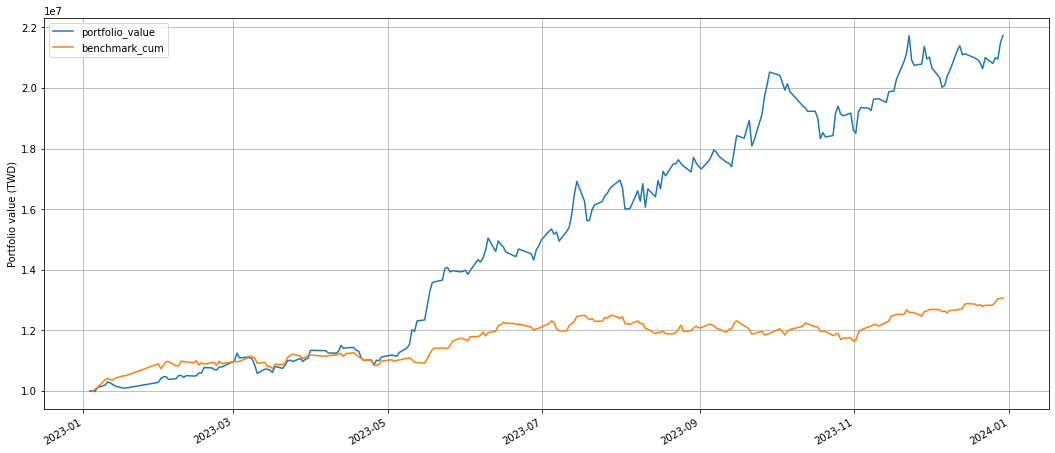

,period_open,period_close,transactions,gross_leverage,net_leverage,starting_cash,orders,ending_cash,starting_exposure,portfolio_value,...,max_leverage,trading_days,period_label,algorithm_period_return,treasury_period_return,algo_volatility,benchmark_period_return,excess_return,benchmark_volatility,benchmark_cum
2023-01-03 13:30:00+08:00,2023-01-03 09:01:00+08:00,2023-01-03 13:30:00+08:00,[],0.000000,0.000000,1.000000e+07,"[{'id': '172c3e5d205c45a0a53eb0f25951e109', 'd...",1.000000e+07,0.00,1.000000e+07,...,0.000000,1,2023-01,0.000000,0.0,NaN,0.000000,0.000000,NaN,NaN
2023-01-04 13:30:00+08:00,2023-01-04 09:01:00+08:00,2023-01-04 13:30:00+08:00,"[{'amount': 8150, 'dt': 2023-01-04 13:30:00+08...",0.285678,0.285678,1.000000e+07,"[{'id': '172c3e5d205c45a0a53eb0f25951e109', 'd...",7.140181e+06,0.00,9.995750e+06,...,0.285678,2,2023-01,-0.000425,0.0,0.004771,-0.001741,0.001316,NaN,9.982590e+06
2023-01-05 13:30:00+08:00,2023-01-05 09:01:00+08:00,2023-01-05 13:30:00+08:00,"[{'amount': 7250, 'dt': 2023-01-05 13:30:00+08...",0.416907,0.416907,7.140181e+06,"[{'id': '172c3e5d205c45a0a53eb0f25951e109', 'd...",5.818655e+06,2855568.75,9.978949e+06,...,0.416907,3,2023-01,-0.002105,0.0,0.013873,0.005424,-0.007529,0.100115,1.005424e+07
2023-01-06 13:30:00+08:00,2023-01-06 09:01:00+08:00,2023-01-06 13:30:00+08:00,"[{'amount': 5652, 'dt': 2023-01-06 13:30:00+08...",0.525185,0.525185,5.818655e+06,"[{'id': '172c3e5d205c45a0a53eb0f25951e109', 'd...",4.798338e+06,4160293.70,1.010569e+07,...,0.525185,4,2023-01,0.010569,0.0,0.106986,0.010506,0.000063,0.073959,1.010506e+07
2023-01-09 13:30:00+08:00,2023-01-09 09:01:00+08:00,2023-01-09 13:30:00+08:00,"[{'amount': 5000, 'dt': 2023-01-09 13:30:00+08...",0.619713,0.619713,4.798338e+06,"[{'id': 'af54d0980f9b44bc8d7cfa79bf7aea6e', 'd...",3.876303e+06,5307355.20,1.019310e+07,...,0.619713,5,2023-01,0.019310,0.0,0.101975,0.037143,-0.017833,0.191248,1.037143e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-25 13:30:00+08:00,2023-12-25 09:01:00+08:00,2023-12-25 13:30:00+08:00,[],0.989365,0.989365,2.212901e+05,[],2.212901e+05,20780212.85,2.080688e+07,...,1.019609,235,2023-12,1.080688,0.0,0.261534,0.283076,0.797612,0.126110,1.283076e+07
2023-12-26 13:30:00+08:00,2023-12-26 09:01:00+08:00,2023-12-26 13:30:00+08:00,[],0.989461,0.989461,2.212901e+05,[],2.212901e+05,20585587.10,2.099750e+07,...,1.019609,236,2023-12,1.099750,0.0,0.261048,0.293786,0.805963,0.126064,1.293786e+07
2023-12-27 13:30:00+08:00,2023-12-27 09:01:00+08:00,2023-12-27 13:30:00+08:00,[],0.989439,0.989439,2.212901e+05,[],2.212901e+05,20776204.95,2.095304e+07,...,1.019609,237,2023-12,1.095304,0.0,0.260554,0.303973,0.791330,0.125989,1.303973e+07
2023-12-28 13:30:00+08:00,2023-12-28 09:01:00+08:00,2023-12-28 13:30:00+08:00,[],0.989701,0.989701,2.212901e+05,[],2.212901e+05,20731746.45,2.148665e+07,...,1.019609,238,2023-12,1.148665,0.0,0.261006,0.305349,0.843316,0.125721,1.305349e+07


In [87]:
from zipline import run_algorithm
from zipline.utils.run_algo import get_transaction_detail

start_date = pd.Timestamp(start, tz = 'utc')
end_date = pd.Timestamp(end, tz = 'utc')  # 轉換成時間序列格式

results = run_algorithm(
    start = start_date,
    end = end_date,
    initialize = initialize,
    handle_data = handle_data,
    analyze = analyze,
    bundle = 'tquant',
    capital_base = capital_base,
)

results  # 回測結果

<Axes: >

findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because 

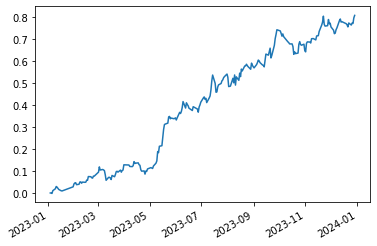

In [88]:
results.returns.cumsum().plot()  # 繪製累積回報圖

## Pyfolio

Pyfolio 與 zipline 的回測結果兼容，讓我們輕鬆用幾行程式碼，就能產出我們需要的投資風險及績效圖表。

p.s. 詳細 Pyfolio 使用方法可參考： TQuant Lab github：[Pyfolio](https://github.com/tejtw/TQuant-Lab/blob/main/lecture/Pyfolio.ipynb)

In [91]:
pip install dask==2.30.0

     |████████████████████████████████| 848 kB 1.3 MB/s eta 0:00:01
  Attempting uninstall: dask
    Found existing installation: dask 2023.5.0
    Uninstalling dask-2023.5.0:
      Successfully uninstalled dask-2023.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
distributed 2021.4.0 requires dask>=2021.03.0, but you have dask 2.30.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [92]:
pip install --upgrade pyfolio

     |████████████████████████████████| 91 kB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 52 kB 2.9 MB/s eta 0:00:01
  Created wheel for pyfolio: filename=pyfolio-0.9.2-py3-none-any.whl size=88667 sha256=aa5021123096eecc9fa9b6bac24e4078fe299d43f2dc3a3ba38d9d5216739145
  Stored in directory: /Users/sue/Library/Caches/pip/wheels/42/16/92/9c9d49efccc497040268960f0825101cc9b1c6e41cdc5a409e
  Created wheel for empyrical: filename=empyrical-0.5.5-py3-none-any.whl size=39764 sha256=945f691b74a2a77265ba132150afb6214fd9cd96cbfe9feb1cddf9f86e503553
  Stored in directory: /Users/sue/Library/Caches/pip/wheels/0d/68/bb/926065fb744e7d7cb67334cb1a9c696722abc8303e5dc9a8d0
Successfully built pyfolio empyrical
Note: you may need to restart the kernel to use updated packages.


In [98]:
pip install --upgrade pyfolio

Note: you may need to restart the kernel to use updated packages.


In [99]:
from functools import partial, update_wrapper
from toolz.functoolz import compose

try:
    from dask.base import apply as dask_apply
except ImportError:
    # Compatibility with older versions of Dask
    from dask.optimize import apply as dask_apply

apply = partial(dask_apply, pure=not compose)
apply.__name__ = 'apply'
apply.__doc__ = (
    'Apply function to all items in an iterator, returning an iterator '
    'of results.'
)
update_wrapper(apply, partial)

functools.partial(<function apply at 0x7fc481182160>, pure=False)

In [100]:
from pyfolio.utils import extract_rets_pos_txn_from_zipline
import pyfolio
returns, positions, transactions = extract_rets_pos_txn_from_zipline(results)  # 從 results 資料表中取出 returns, positions & transactions
benchmark_rets = results.benchmark_return  # 取出 benchmark 的報酬率

<Axes: title={'center': 'Rolling Sharpe ratio (6-month)'}, ylabel='Sharpe ratio'>

findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because 

findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because 

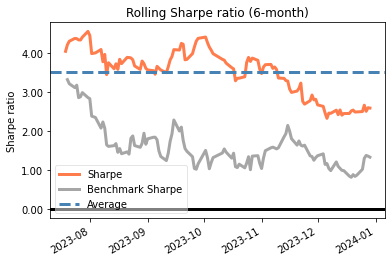

In [101]:
# 繪製夏普比率圖

from pyfolio.plotting import plot_rolling_sharpe

plot_rolling_sharpe(returns,
                    factor_returns=benchmark_rets)

In [107]:
#其中，returns 是投资组合的回报率序列，np.sqrt(252) 是用于将日回报率转换为年回报率的因子。
import pyfolio as pf
import numpy as np

# 计算夏普比率
sharpe_ratio = (returns.mean() * np.sqrt(252)) / returns.std()

# 添加实际夏普比率
print(f'實際夏普比率：{sharpe_ratio:.2f}')


實際夏普比率：3.28


findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because 

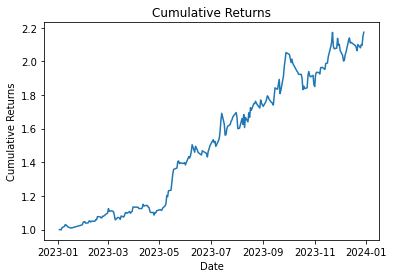

累積報酬率（最後一個值）：
2.1732438043927984


In [118]:
import matplotlib.pyplot as plt
import pyfolio as pf

# 计算累积回报率
rets, _, _ = extract_rets_pos_txn_from_zipline(results)

# 计算性能统计
perf_stats = pf.timeseries.perf_stats(rets)

# 绘制累积回报率图
cum_rets = (1 + rets).cumprod()
plt.plot(cum_rets)
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns')
plt.show()
print("累積報酬率（最後一個值）：")
print(cum_rets.iloc[-1])


In [115]:
import pyfolio as pf

pf.create_full_tear_sheet(returns)

AttributeError: 'Series' object has no attribute 'iteritems'

In [116]:
import pyfolio as pf
import empyrical

bt_returns, bt_positions, bt_transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)
benchmark_rets = results.benchmark_return

bt_returns.index = bt_returns.index.tz_localize(None).tz_localize('UTC')
bt_positions.index = bt_positions.index.tz_localize(None).tz_localize('UTC')
bt_transactions.index = bt_transactions.index.tz_localize(None).tz_localize('UTC')
benchmark_rets.index = benchmark_rets.index.tz_localize(None).tz_localize('UTC')

# Creating a Full Tear Sheet
pf.create_full_tear_sheet(bt_returns, positions=bt_positions, transactions=bt_transactions,
                          benchmark_rets=benchmark_rets,
                          #live_start_date='2022-01-01', 
                          round_trips=False)

AttributeError: 'Series' object has no attribute 'iteritems'

## 額外補充：查看 positions, transactions & orders 資料表

In [33]:
# 取出 results 中的 positions, transactions & orders 資料表
positions, transactions, orders = get_transaction_detail(results)   

In [ ]:
positions

In [ ]:
transactions

In [ ]:
orders

In [ ]:
orders[orders['symbol'] == '3557']

In [ ]:
orders.loc['2023-01-03']